_Building something using data?_

The Socrata Open Data API allows you to programmatically access a wealth of open data resources from governments, non-profits, and NGOs around the world.

https://dev.socrata.com/


The *CDC* data is avalable over Socrata API:
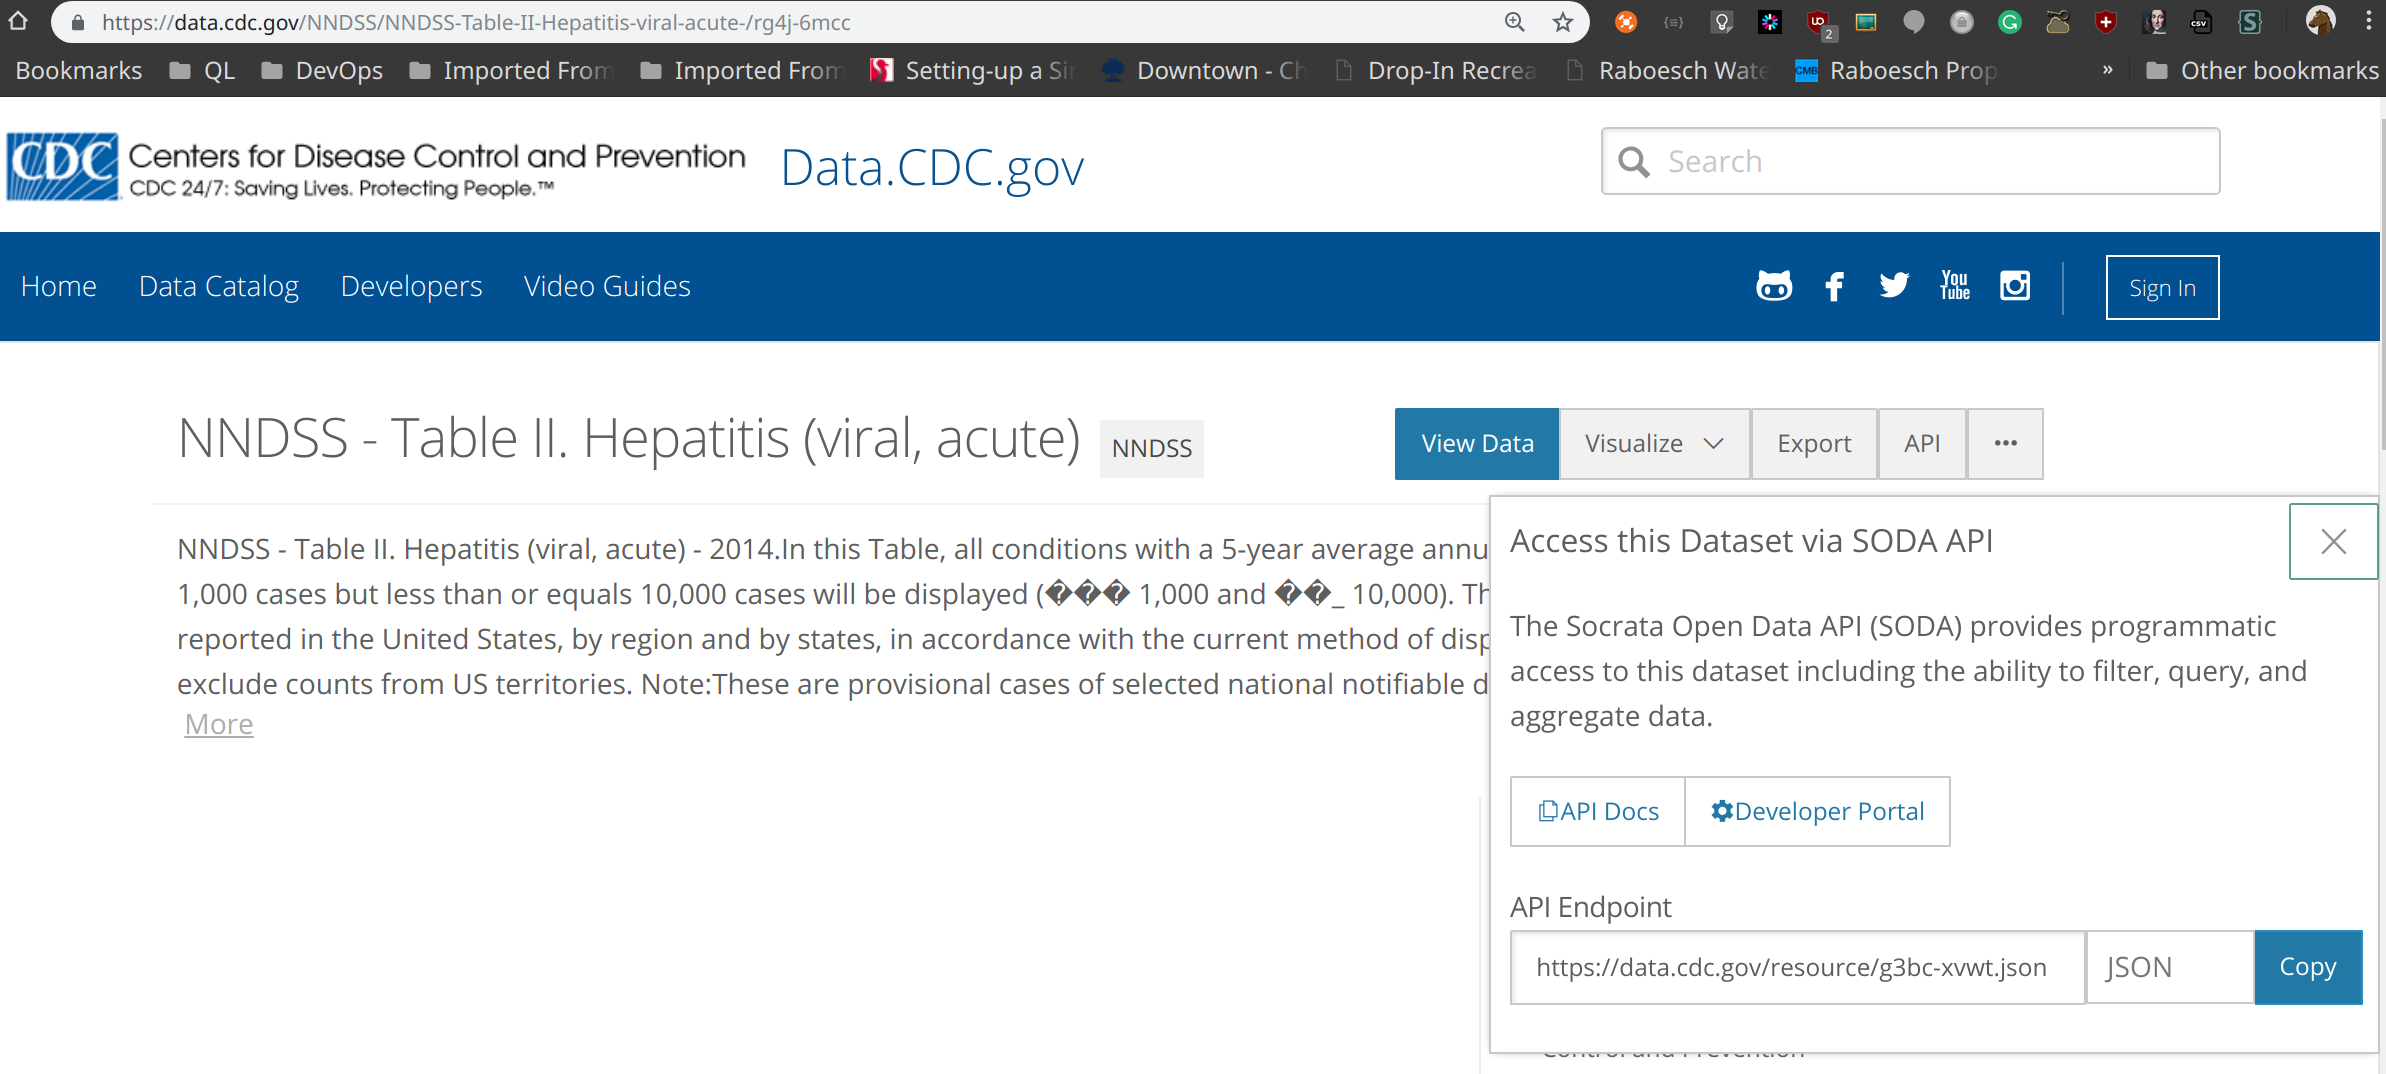




Python bindings for the Socrata Open Data API
* Install sodapy into current notebook environment

In [1]:
import sys
!{sys.executable} -m pip install sodapy
import pandas
import numpy
import os
from sodapy import Socrata

Define list of datasets to work with by providing Socrata dataset IDs.
The quiry used to find these:
https://healthdata.gov/search/type/dataset?query=2017%20%22Table%20II%22&sort_by=changed&sort_order=DESC&q=search/type/dataset&page=1


In [2]:
datasets = ["rxmp-xjpc","ttj2-zsyk", "i42d-szcv", 
            "6rpz-c2y5", "9qys-crt2","acdz-tk8j", 
            "n24i-76tn", "btcp-84tv", "m6gf-vfkz"]


Connect to the site `"data.cdc.gov"`

In [4]:
client = Socrata("data.cdc.gov", None)#, os.environ['SOCRATA_TOKEN'])

Define what methadata about columns to print for evaluation

In [5]:
column_properties_we_want_to_see = [
        'dataTypeName',
        'fieldName',
        'width']

All files have these three columns ['reporting_area','mmwr_year','mmwr_week' ].

Other columns named consistently with most formatted as `decease + measure_name`. The `measure name` usually have a suffix further describing the constract.
 
Example:

* `west_nile_virus_disease_neuroinvasive_previous_52_weeks_max`
* `hepatitis_viral_acute_type_c_previous_52_weeks_med`

Some are informative a very paricular

* `vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_previous_52_weeks_max`


There are planty of columns having `_flag` postfix

In [6]:
remove_flags= lambda row: dict(filter(lambda kv: not kv[0].endswith('_flag'), row.items()))

The json numeric data quoted and DataFrame fiels has Objet type insted on Number.
```json
{'zika_virus_disease_non_congenital_previous_52_weeks_max': '3', 'west_nile_virus_disease_nonneuroinvasive_previous_52_weeks_med': '0'}
```
Supply function that converts field to INT 

In [7]:
to_numbers= lambda row: dict(map(lambda kv: (kv[0],int(str(kv[1]))) if str(kv[1]).isnumeric() else kv, row.items()))


We'll aggregate columns from different files by adding on the right where aggregated_by matches.

In [8]:
aggregate_by = ['reporting_area','mmwr_year','mmwr_week' ]


In [27]:

all_three=[]
union_of_all_files_df= None

for dataset in datasets:
    metadata= client.get_metadata(dataset)
    print(metadata['name'])
    all_metadata_about_columns = metadata['columns']
    for a_meta in all_metadata_about_columns:
        out=""
        for meta_key, meta_value in a_meta.items():
            if meta_key in column_properties_we_want_to_see:
                #out+=meta_key
                #out+=" => "
                out+=str(meta_value)
                out+=", "
        #if out:
        #    print(out)
        #    print('--------------------------')

    il= client.get(dataset, reporting_area='ILLINOIS')
    #print(il)
    mi= client.get(dataset, reporting_area='MICHIGAN')
    oh= client.get(dataset, reporting_area='OHIO')
    states=il+mi+oh
    # all_three+=
    all_ = list(map(remove_flags, states))
    all__ = list(map(to_numbers, all_))
    print(len(all__))
    current_df= pandas.io.json.json_normalize(all__)
    current_df.reset_index()
    if 'location_1.human_address' in current_df.columns:
        current_df.drop(['location_1.human_address'
                     ,'location_1.latitude'
                     ,'location_1.longitude'
                     ,'location_1.needs_recoding'], axis=1, inplace=True)
    if 'location_2.human_address' in current_df.columns:
        current_df.drop(['location_2.human_address'
                     ,'location_2.latitude'
                     ,'location_2.longitude'
                     ,'location_2.needs_recoding'], axis=1, inplace=True) 
    #print(current_df.dtypes)
    #print(current_df.index)
    #print(current_df.columns)
    print(client.get_metadata(dataset)['tags'])
    #current_df.set_index(['reporting_area','mmwr_year','mmwr_week'],inplace=True)
    if union_of_all_files_df is not None:
        union_of_all_files_df = union_of_all_files_df.merge(current_df, 
                                    how='outer', on=['reporting_area',
                                                     'mmwr_year',
                                                     'mmwr_week'])
        
    else:
        union_of_all_files_df = current_df
        current_df = None
        print("Init done ")          
        

union_of_all_files_df.set_index(['reporting_area','mmwr_year','mmwr_week'],inplace=True)
        
print("Columns ",union_of_all_files_df.columns)          
#print(union_of_all_files_df.describe())
#print(union_of_all_files_df.index)

print("Before dedup shape is: ", union_of_all_files_df.shape)
print(union_of_all_files_df.drop_duplicates(inplace= True))
print("After dedup shape is: ", union_of_all_files_df.shape)
file= open('result.csv','w')
union_of_all_files_df.to_csv(file)
file.close()

#selected_columns_data = 
#for a_column_meta in column_properties_we_want_to_see:
    

#client.get("ttj2-zsyk", limit=2)

NNDSS - Table II. West Nile to Zika
156
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'west nile virus disease', 'zika virus disease', 'non-congenital']
Init done 
NNDSS - Table II. Vibriosis
156
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'vibriosis']
NNDSS - Table II. Tetanus to Varicella
156
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'tetanus', 'varicella morbidity']
NNDSS - Table II. Salmonellosis (excluding typhoid fever and paratyphoid fever) to Shigellosis
159
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'salmonellosis (excluding typhoid fever and paratyphoid fever)', 'shiga toxin-producing escherichia coli', 'shigellosis']
NNDSS - Table II. Meningococcal disease to Pertussis
156
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'meningococcal disease', 'all serogroups', 'mumps', 'pertussis']
NNDSS - Table II. Legionellosis to Malaria
156
['2018', 'nndss', 'wonder', 'nedss', 'netss', 'legionellosis', 'malaria']
NNDSS - Table II. Invasive pneumococcal disease, all ages
168
['20